<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=150px> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>Graph Connectivity</h1>
        <h1>Strongly and Weakly Connected Components</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

import tqdm as tq
from tqdm import tqdm
import os

import networkx as nx
import random
import wget

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 850d3ee8182d294456ba5884f220e1d75132dce0

wget      : 3.2
watermark : 2.1.0
numpy     : 1.20.1
pandas    : 1.2.2
matplotlib: 3.3.2
tqdm      : 4.50.2
networkx  : 2.5
json      : 2.0.9



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Example Network

In [4]:
G_test = nx.DiGraph()
G_test.add_edges_from([
    (0, 1),
    (0, 3),
    (1, 2),
    (1, 4),
    (2, 0),
    (2, 6),
    (3, 2),
    (4, 5),
    (4, 6),
    (5, 6),
    (5, 7),
    (5, 8),
    (5, 9),
    (6, 4),
    (7, 9),
    (8, 9),
    (9, 8),
    (10, 11),
    (11, 12),
    (12, 10),
    (11, 13),
    (11, 14),
    (11, 16),
    (13, 15),
    (14, 15)
])

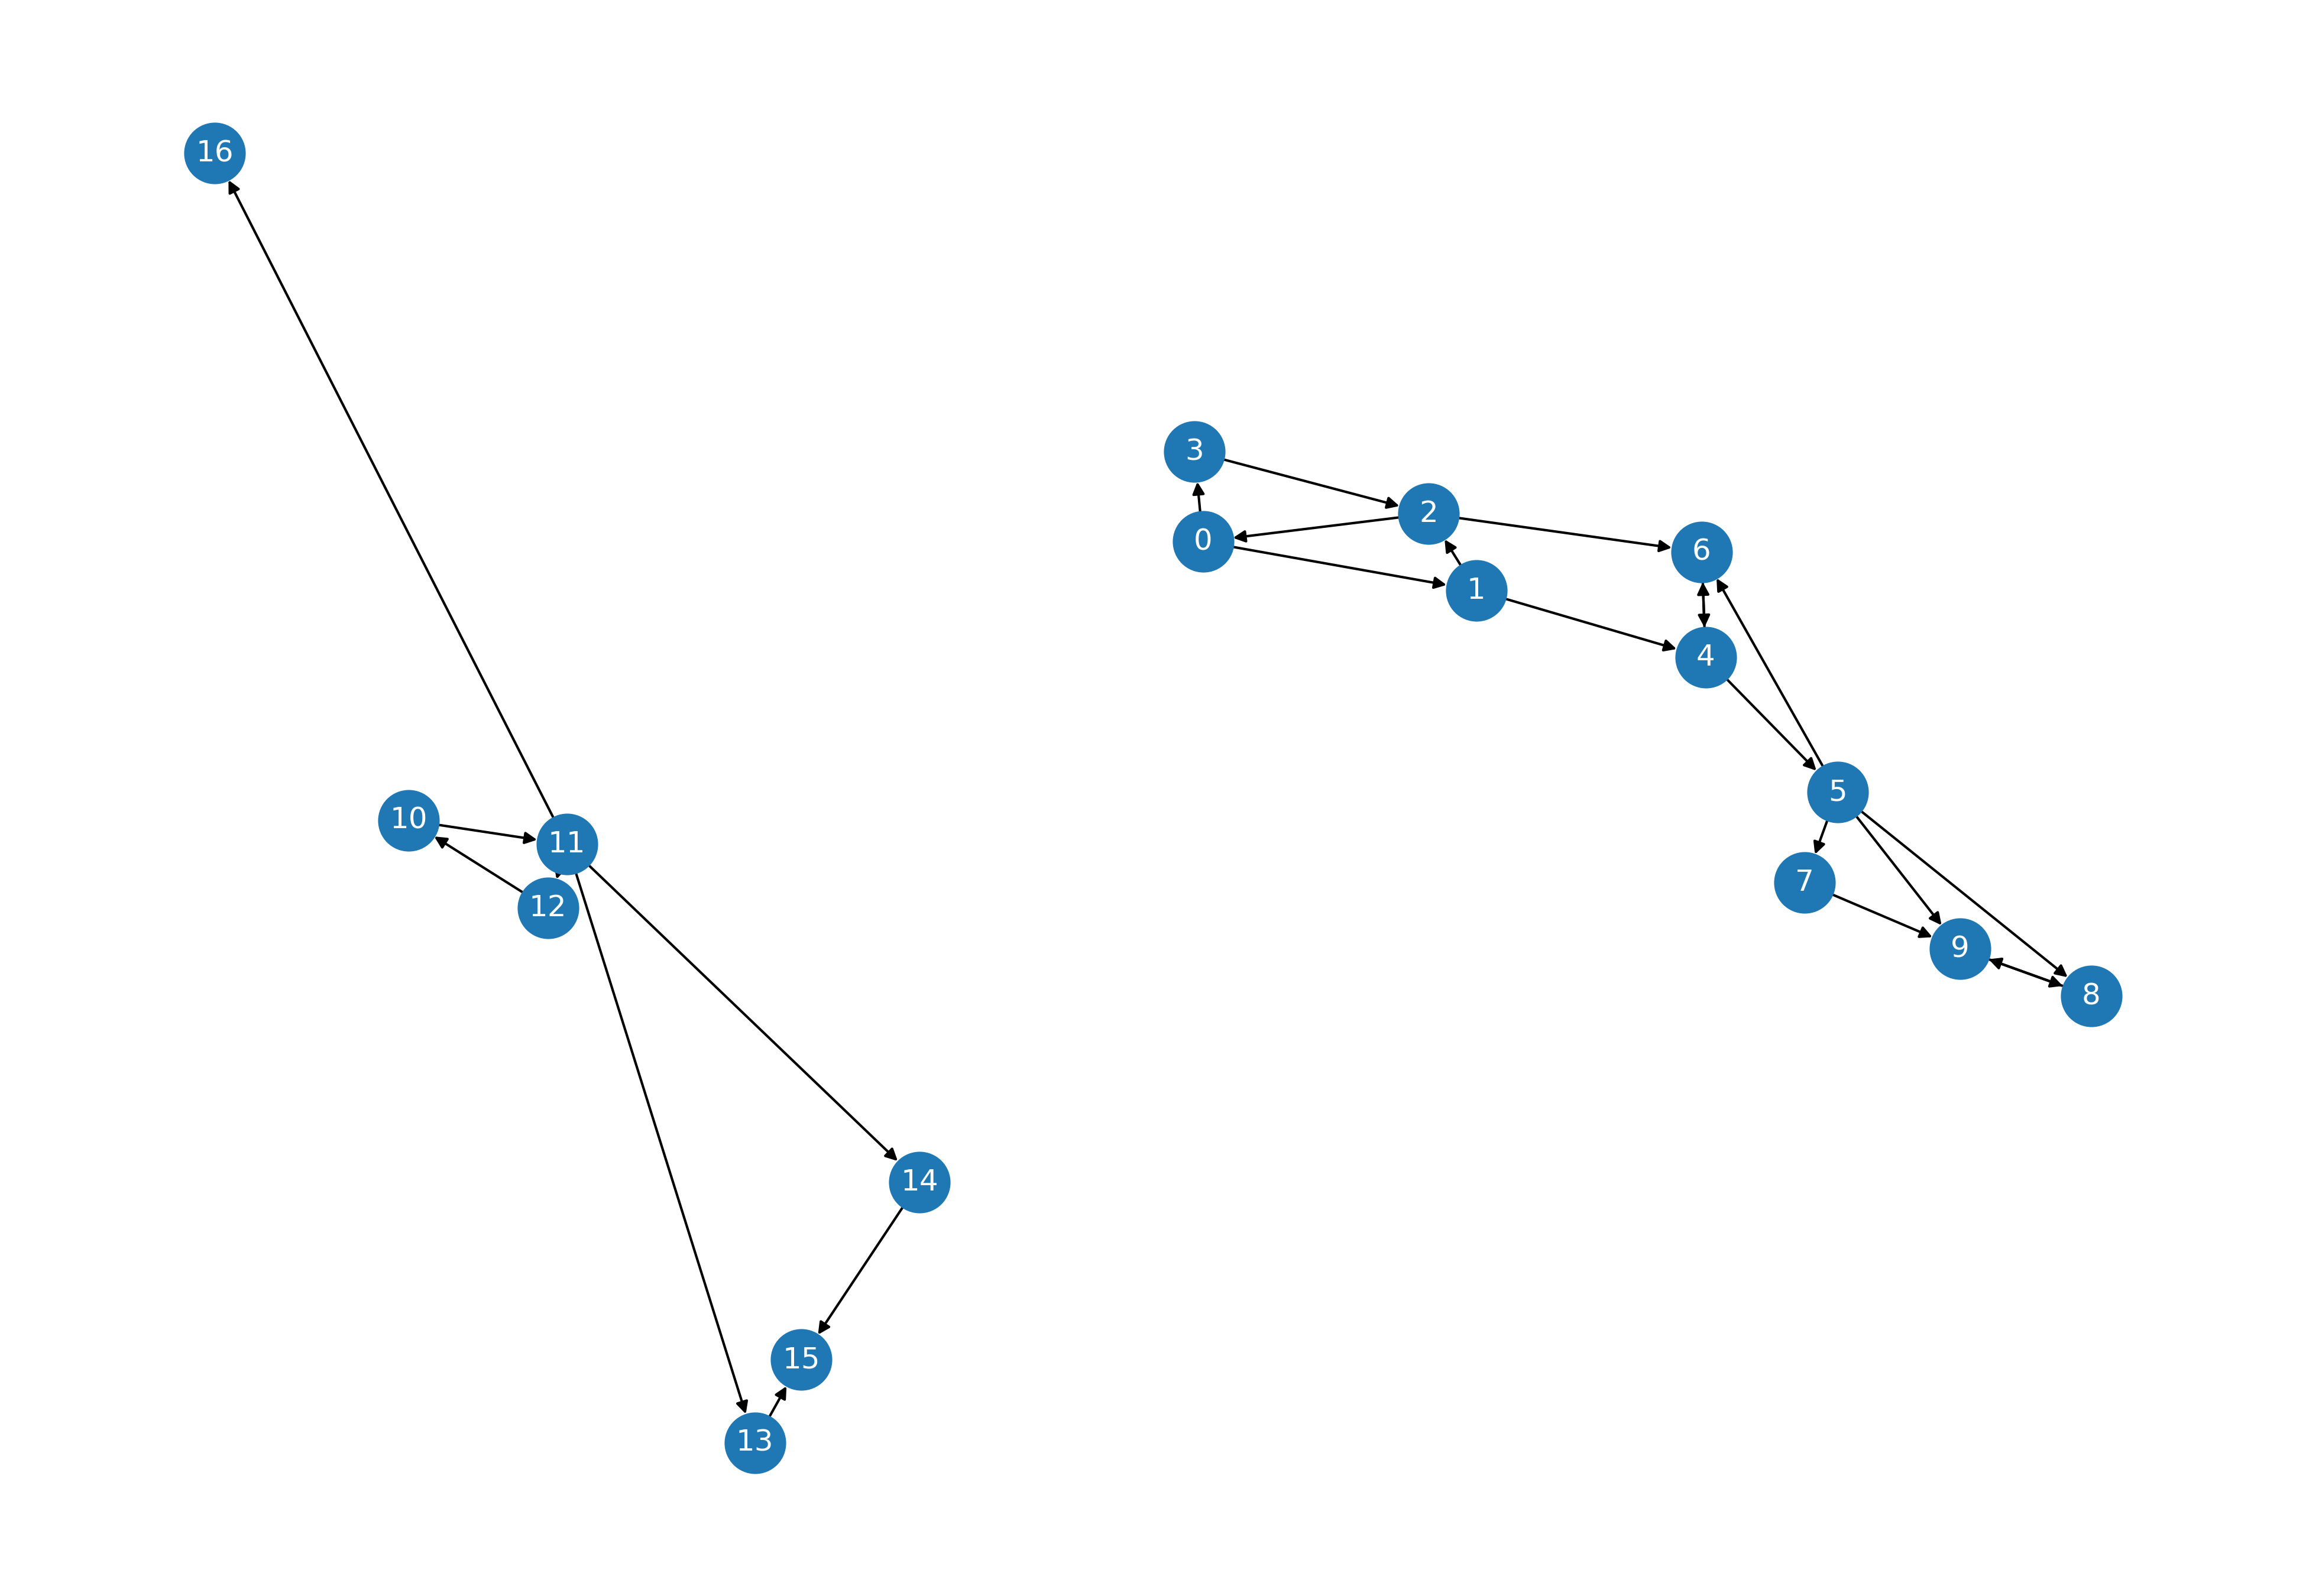

In [5]:
np.random.seed(1337)
random.seed(1337)
G_pos = nx.layout.fruchterman_reingold_layout(G_test)
nx.draw(G_test, pos=G_pos, node_size=600)
nx.draw_networkx_labels(G_test, pos=G_pos, font_color='white');

# Weakly Connected Components

In [6]:
def weakly_connected_components(G):
    nodes = {}
    components = {}
    component_count = 0

    for node_i, node_j in G.edges:
        # Both nodes are new
        if node_i not in nodes and node_j not in nodes:
            nodes[node_i] = component_count
            nodes[node_j] = component_count
            components[component_count] = set([node_i, node_j])
            component_count += 1

        # Both nodes have already been seen
        elif node_i in nodes and node_j in nodes:
            component_i = nodes[node_i]
            component_j = nodes[node_j]

            # Nothing to do
            if component_i == component_j:
                continue
            else:
                keep, remove = (component_i, component_j) if \
                component_j > component_i else (component_j, component_i)

                components[keep] |= components[remove]
                for node in components[remove]:
                    nodes[node] = keep

                del components[remove]

        # Node_j is new
        elif node_i in nodes and node_j not in nodes:
            component_i = nodes[node_i]
            nodes[node_j] = component_i
            components[component_i].add(node_j)

        # Node_i is new
        elif node_j in nodes and node_i not in nodes:
            component_j = nodes[node_j]
            nodes[node_i] = component_j
            components[component_j].add(node_i)
   
    return list(components.values())

We find 2 weakly connected components in our test network

In [7]:
WCC = weakly_connected_components(G_test)
print(WCC)

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}, {10, 11, 12, 13, 14, 15, 16}]


A quick visualization can confirm that they are reasonable

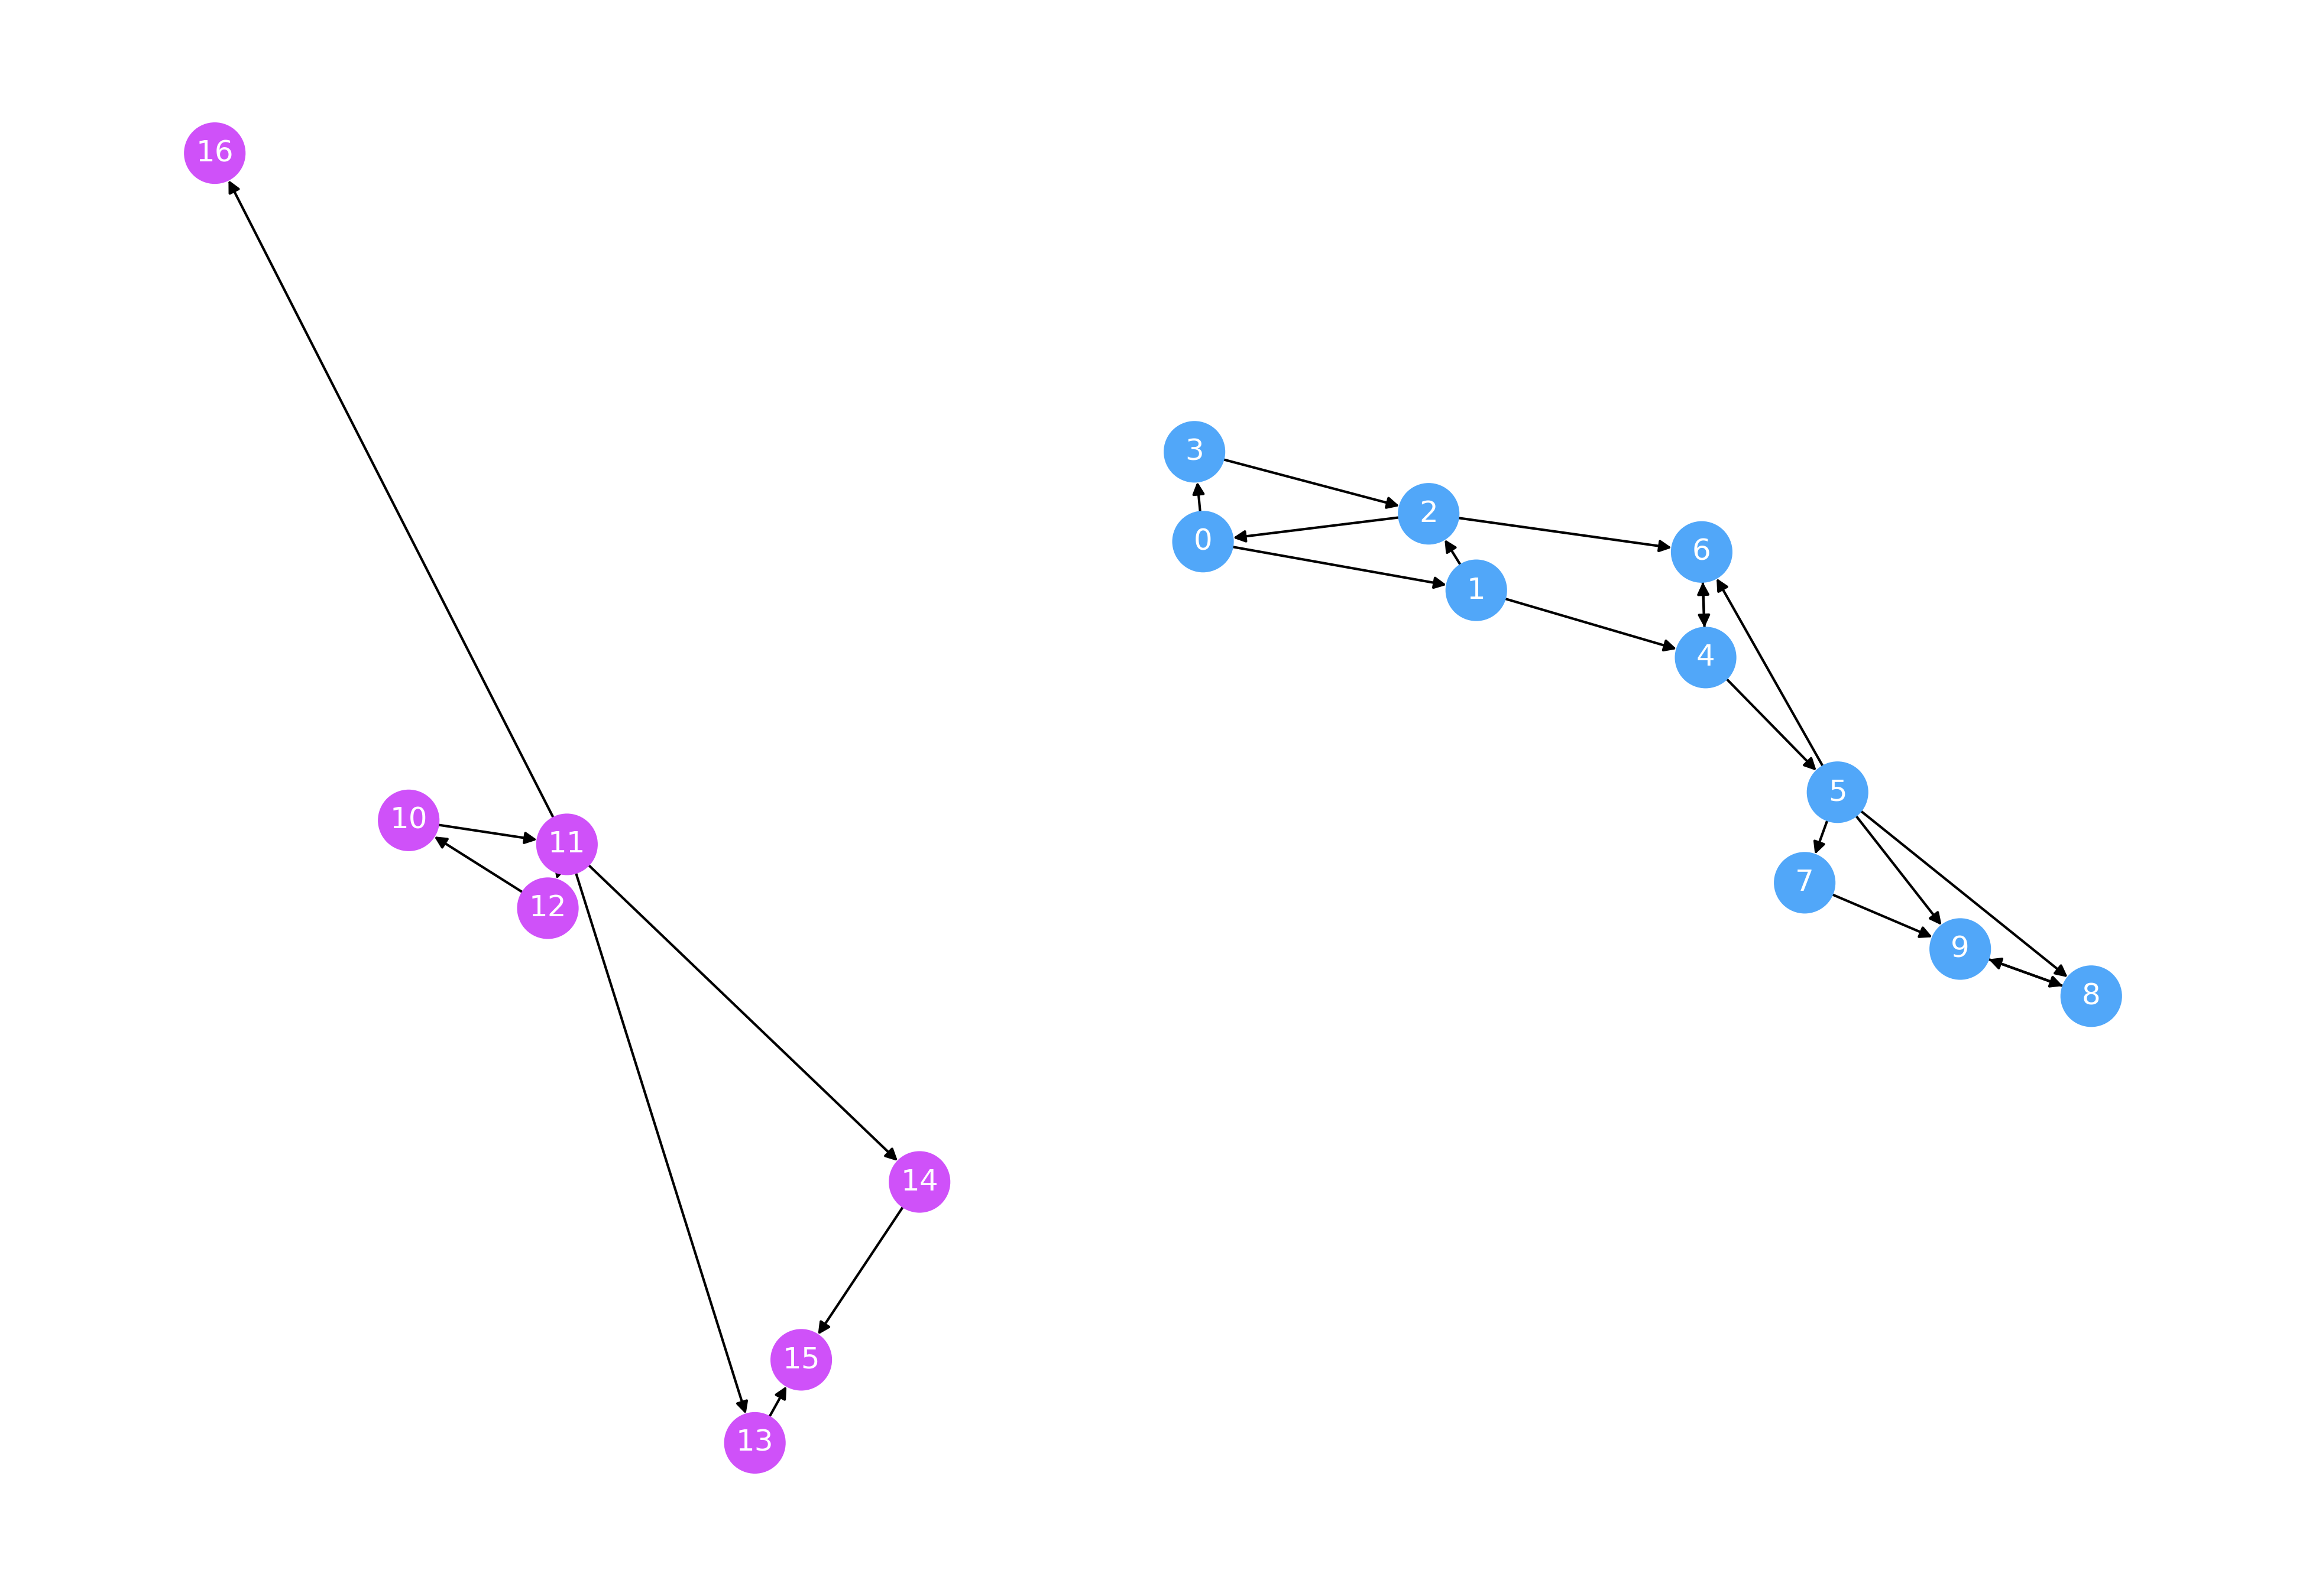

In [8]:
node_colors = [colors[0] if node in WCC[0] else colors[1] for node in G_test.nodes]

nx.draw(G_test, pos=G_pos, node_size=600, node_color=node_colors)
nx.draw_networkx_labels(G_test, pos=G_pos, font_color='white');

Let us now consider a more interesting example

## Load the Higgs Reply Network

In [9]:
filename = 'data/higgs-reply_network.edgelist.gz'
url = 'https://snap.stanford.edu/data/higgs-reply_network.edgelist.gz'

if not os.path.exists(filename):
    progress_bar = None

    def tqdm_bar(current, total, width=80):
        global progress_bar

        if progress_bar is None:
            progress_bar = tqdm(total=total, unit='iB')
        
        progress_bar.update(current)
    
    print('Downloading File')
    wget.download(url, filename, bar=tqdm_bar)

reply = pd.read_csv(filename, sep=' ', 
                    header=None, names=['node_i', 'node_j', 'weight'])

Create the graph

In [10]:
G = nx.DiGraph()
G.add_edges_from(reply[['node_i', 'node_j']].values)

In [11]:
G.number_of_nodes()

38918

In [12]:
G.number_of_edges()

32523

In [13]:
WCC = weakly_connected_components(G)

We find 10641 components, as expected

In [14]:
print("Our algorithm:", len(WCC))
print("NetworkX:", nx.components.number_weakly_connected_components(G))

Our algorithm: 10641
NetworkX: 10641


We also extract the size of each WCC

In [15]:
WCC_sizes = [len(comp) for comp in WCC]

And the largest WCC has over 12k nodes

In [16]:
np.max(WCC_sizes)

12839

In [17]:
P_size = pd.DataFrame(list(Counter(WCC_sizes).items()), columns=['size', 'N_size'])
P_size.sort_values('size', inplace=True)
P_size['N_size'] /= P_size['N_size'].sum()

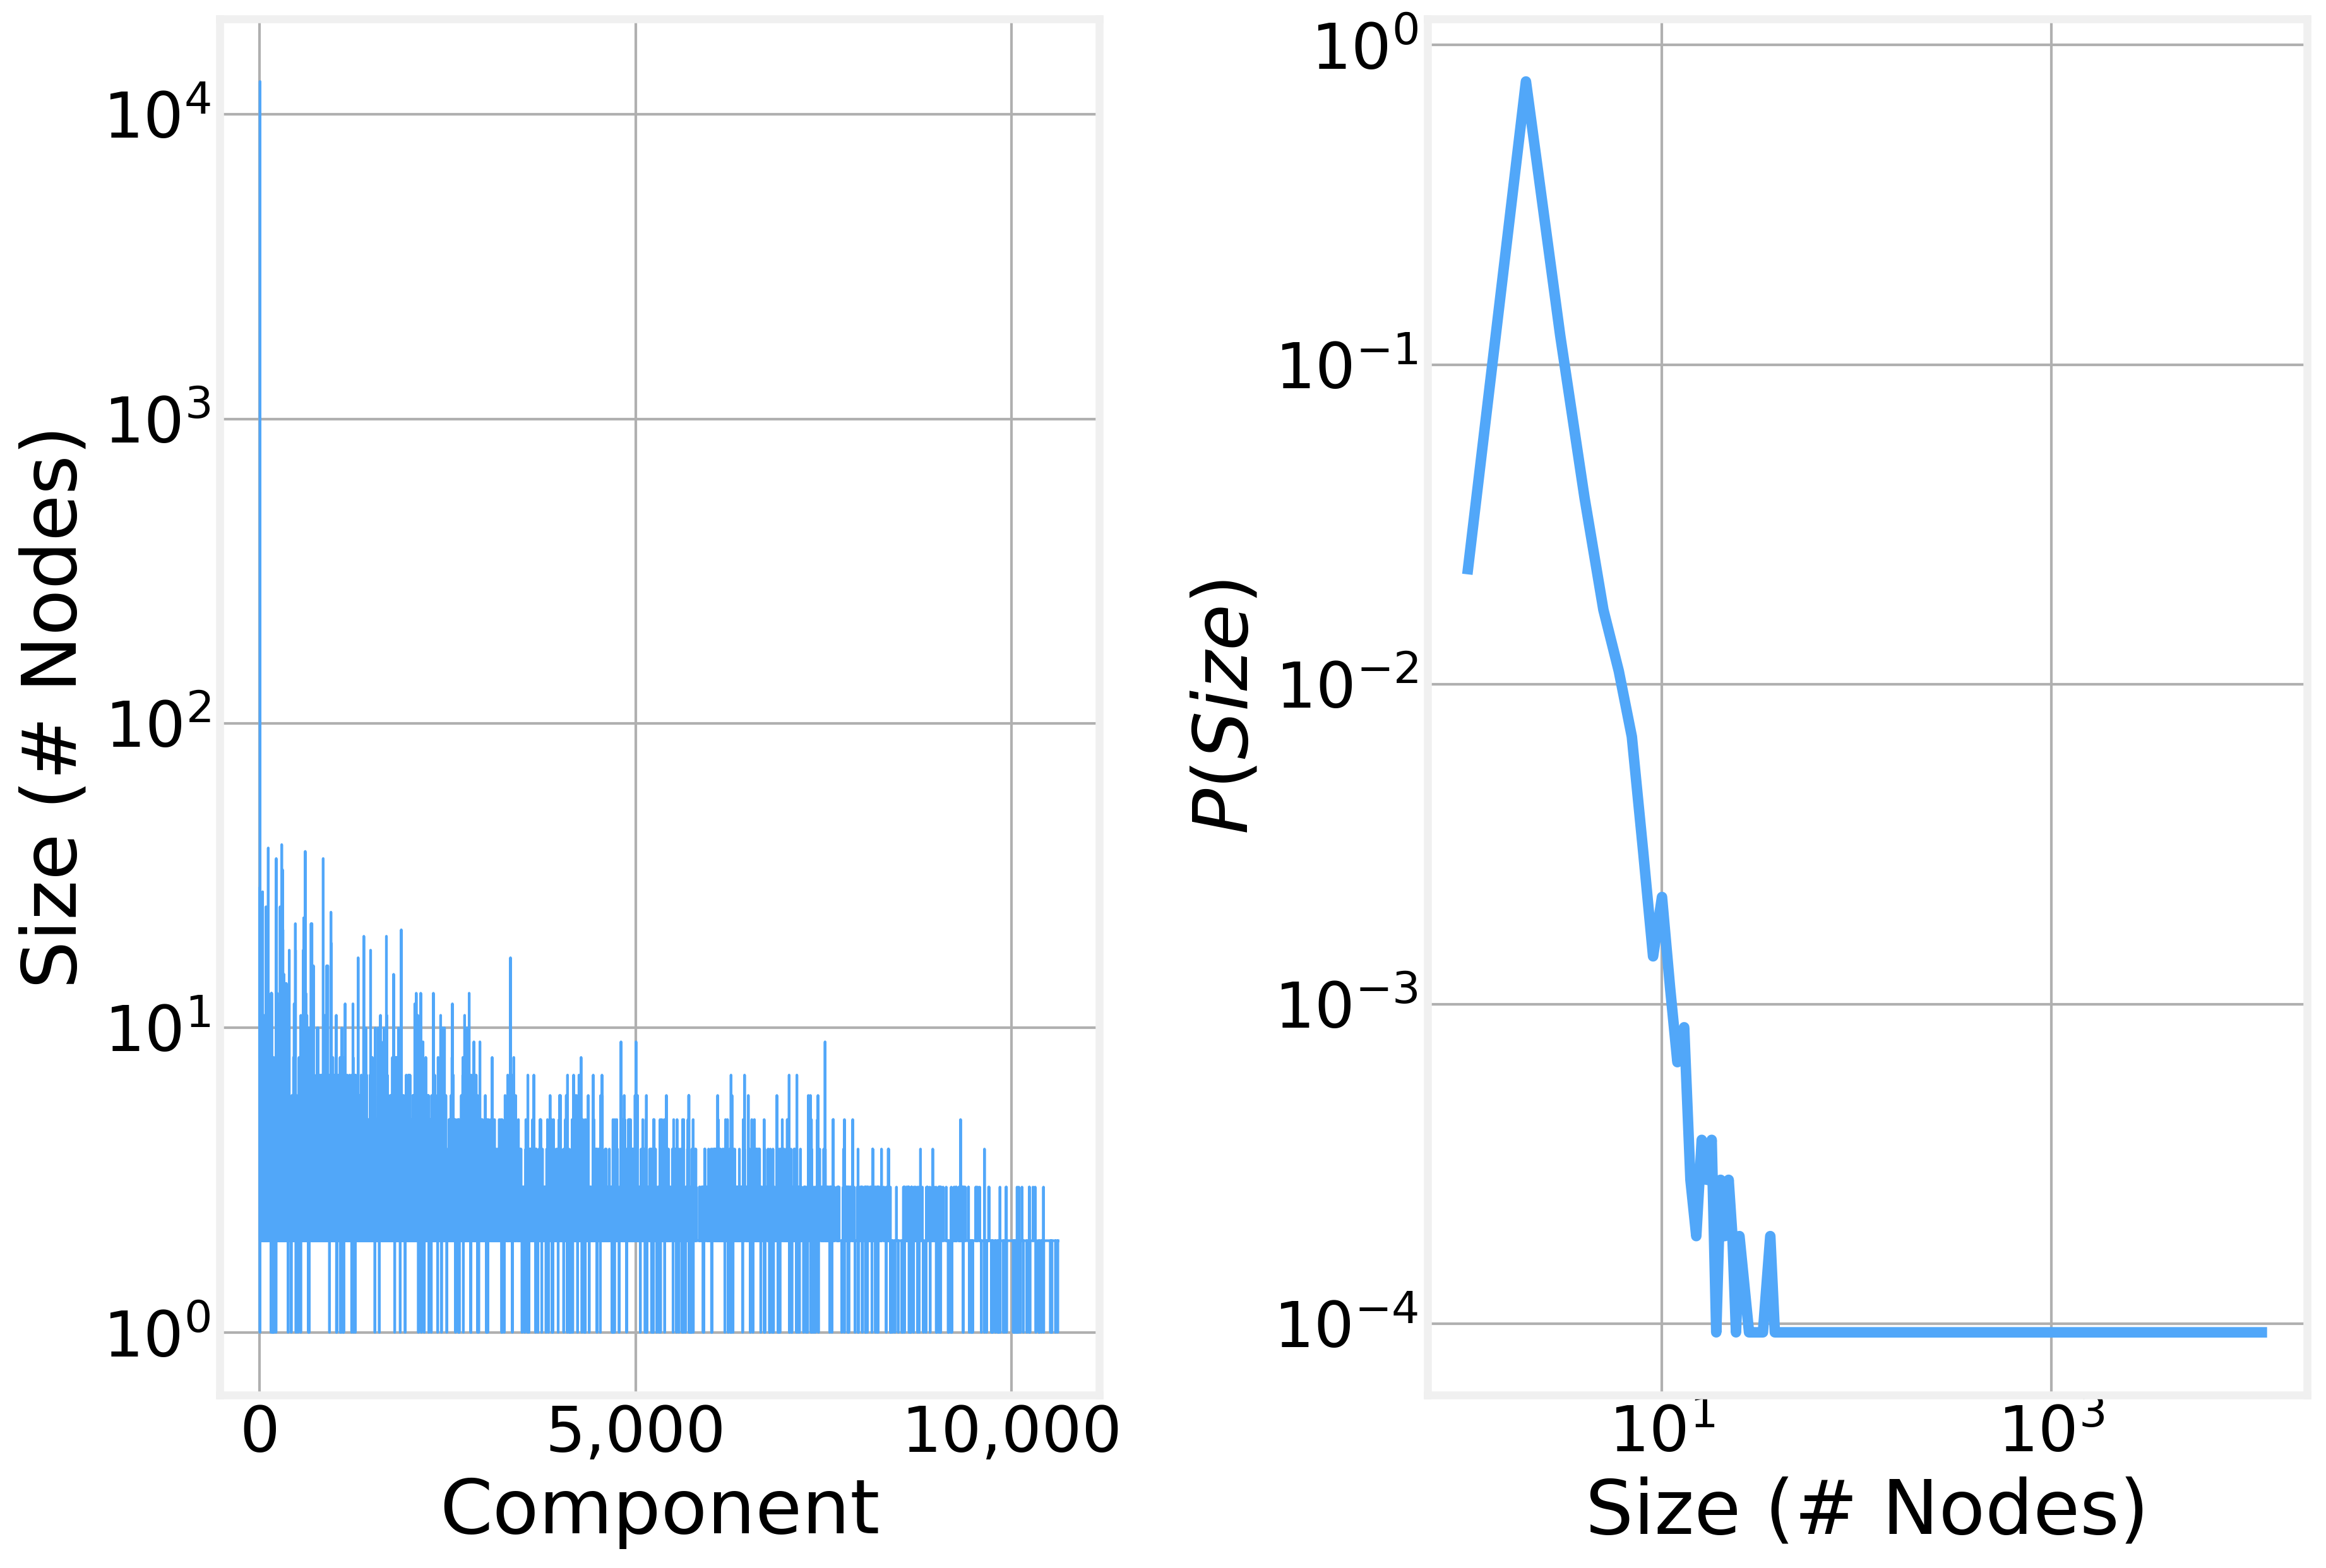

In [18]:
fig, (ax, ax2) = plt.subplots(1, 2)

ax.plot(WCC_sizes, lw=1)
ax.set_yscale('log')
ax.set_xlabel('Component')
ax.set_ylabel('Size (# Nodes)')
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

P_size.plot(x='size', y='N_size', legend=False, ax=ax2)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('Size (# Nodes)')
ax2.set_ylabel(r'$P\left(Size\right)$')
fig.tight_layout()

The most common size is 4 nodes, accounting for almost 4% of the total number of components

In [19]:
P_size.iloc[P_size['N_size'].idxmax()]

size      4.000000
N_size    0.038342
Name: 7, dtype: float64

We extract the largest subgraph

In [20]:
largest_WCC = G.subgraph(WCC[np.argmax(WCC_sizes)])

In [21]:
print('Number of nodes:', largest_WCC.number_of_nodes())
print('Number of edges:', largest_WCC.number_of_edges())

Number of nodes: 12839
Number of edges: 14944


# Strongly Connected Components

In [22]:
def strongly_connected_components(G):
    visited = {}
    first_seen = {}
    stack = []
    full_comps = []
    G1 = G.copy() 
    G1.graph['t'] = 0

    # Perform DFS starting from a specific node
    def traverse(G, node_i, first_seen, visited, stack):
        visited[node_i] = G.graph['t']
        first_seen[node_i] = G.graph['t']
        G.graph['t'] += 1
        stack.append(node_i)

        full_comps = []

        for node_j in G[node_i]:
            if node_j not in visited:

                comps = traverse(G, node_j, first_seen, visited, stack)

                if len(comps) != 0:
                    full_comps.extend(comps)

                first_seen[node_i] = min(first_seen[node_i], first_seen[node_j])

            elif node_j in stack:
                first_seen[node_i] = min(first_seen[node_i], visited[node_j])

        node_k = -1
        
        # When we wrap around we found a SCC
        # and node_i is the root
        if first_seen[node_i] == visited[node_i]:
            comps = set([])
            
            while node_k != node_i:
                node_k = stack.pop()
                comps.add(node_k)

            full_comps.append(comps)

        return full_comps

    # Perform a DFS starting from each node in turn
    for node_i in G1.nodes:
        # Skip nodes that have already been seen
        if node_i not in visited:
            comps = traverse(G1, node_i, first_seen, visited, stack)
            full_comps.extend(comps)

    return full_comps

In [23]:
SCC_test = strongly_connected_components(G_test)

Now we find that our test network has 9 strongly connected compoenents that subdivide each of our previously found WCC.

In [24]:
SCC_test

[{8, 9}, {7}, {4, 5, 6}, {0, 1, 2, 3}, {15}, {13}, {14}, {16}, {10, 11, 12}]

A quick visualization makes this clear

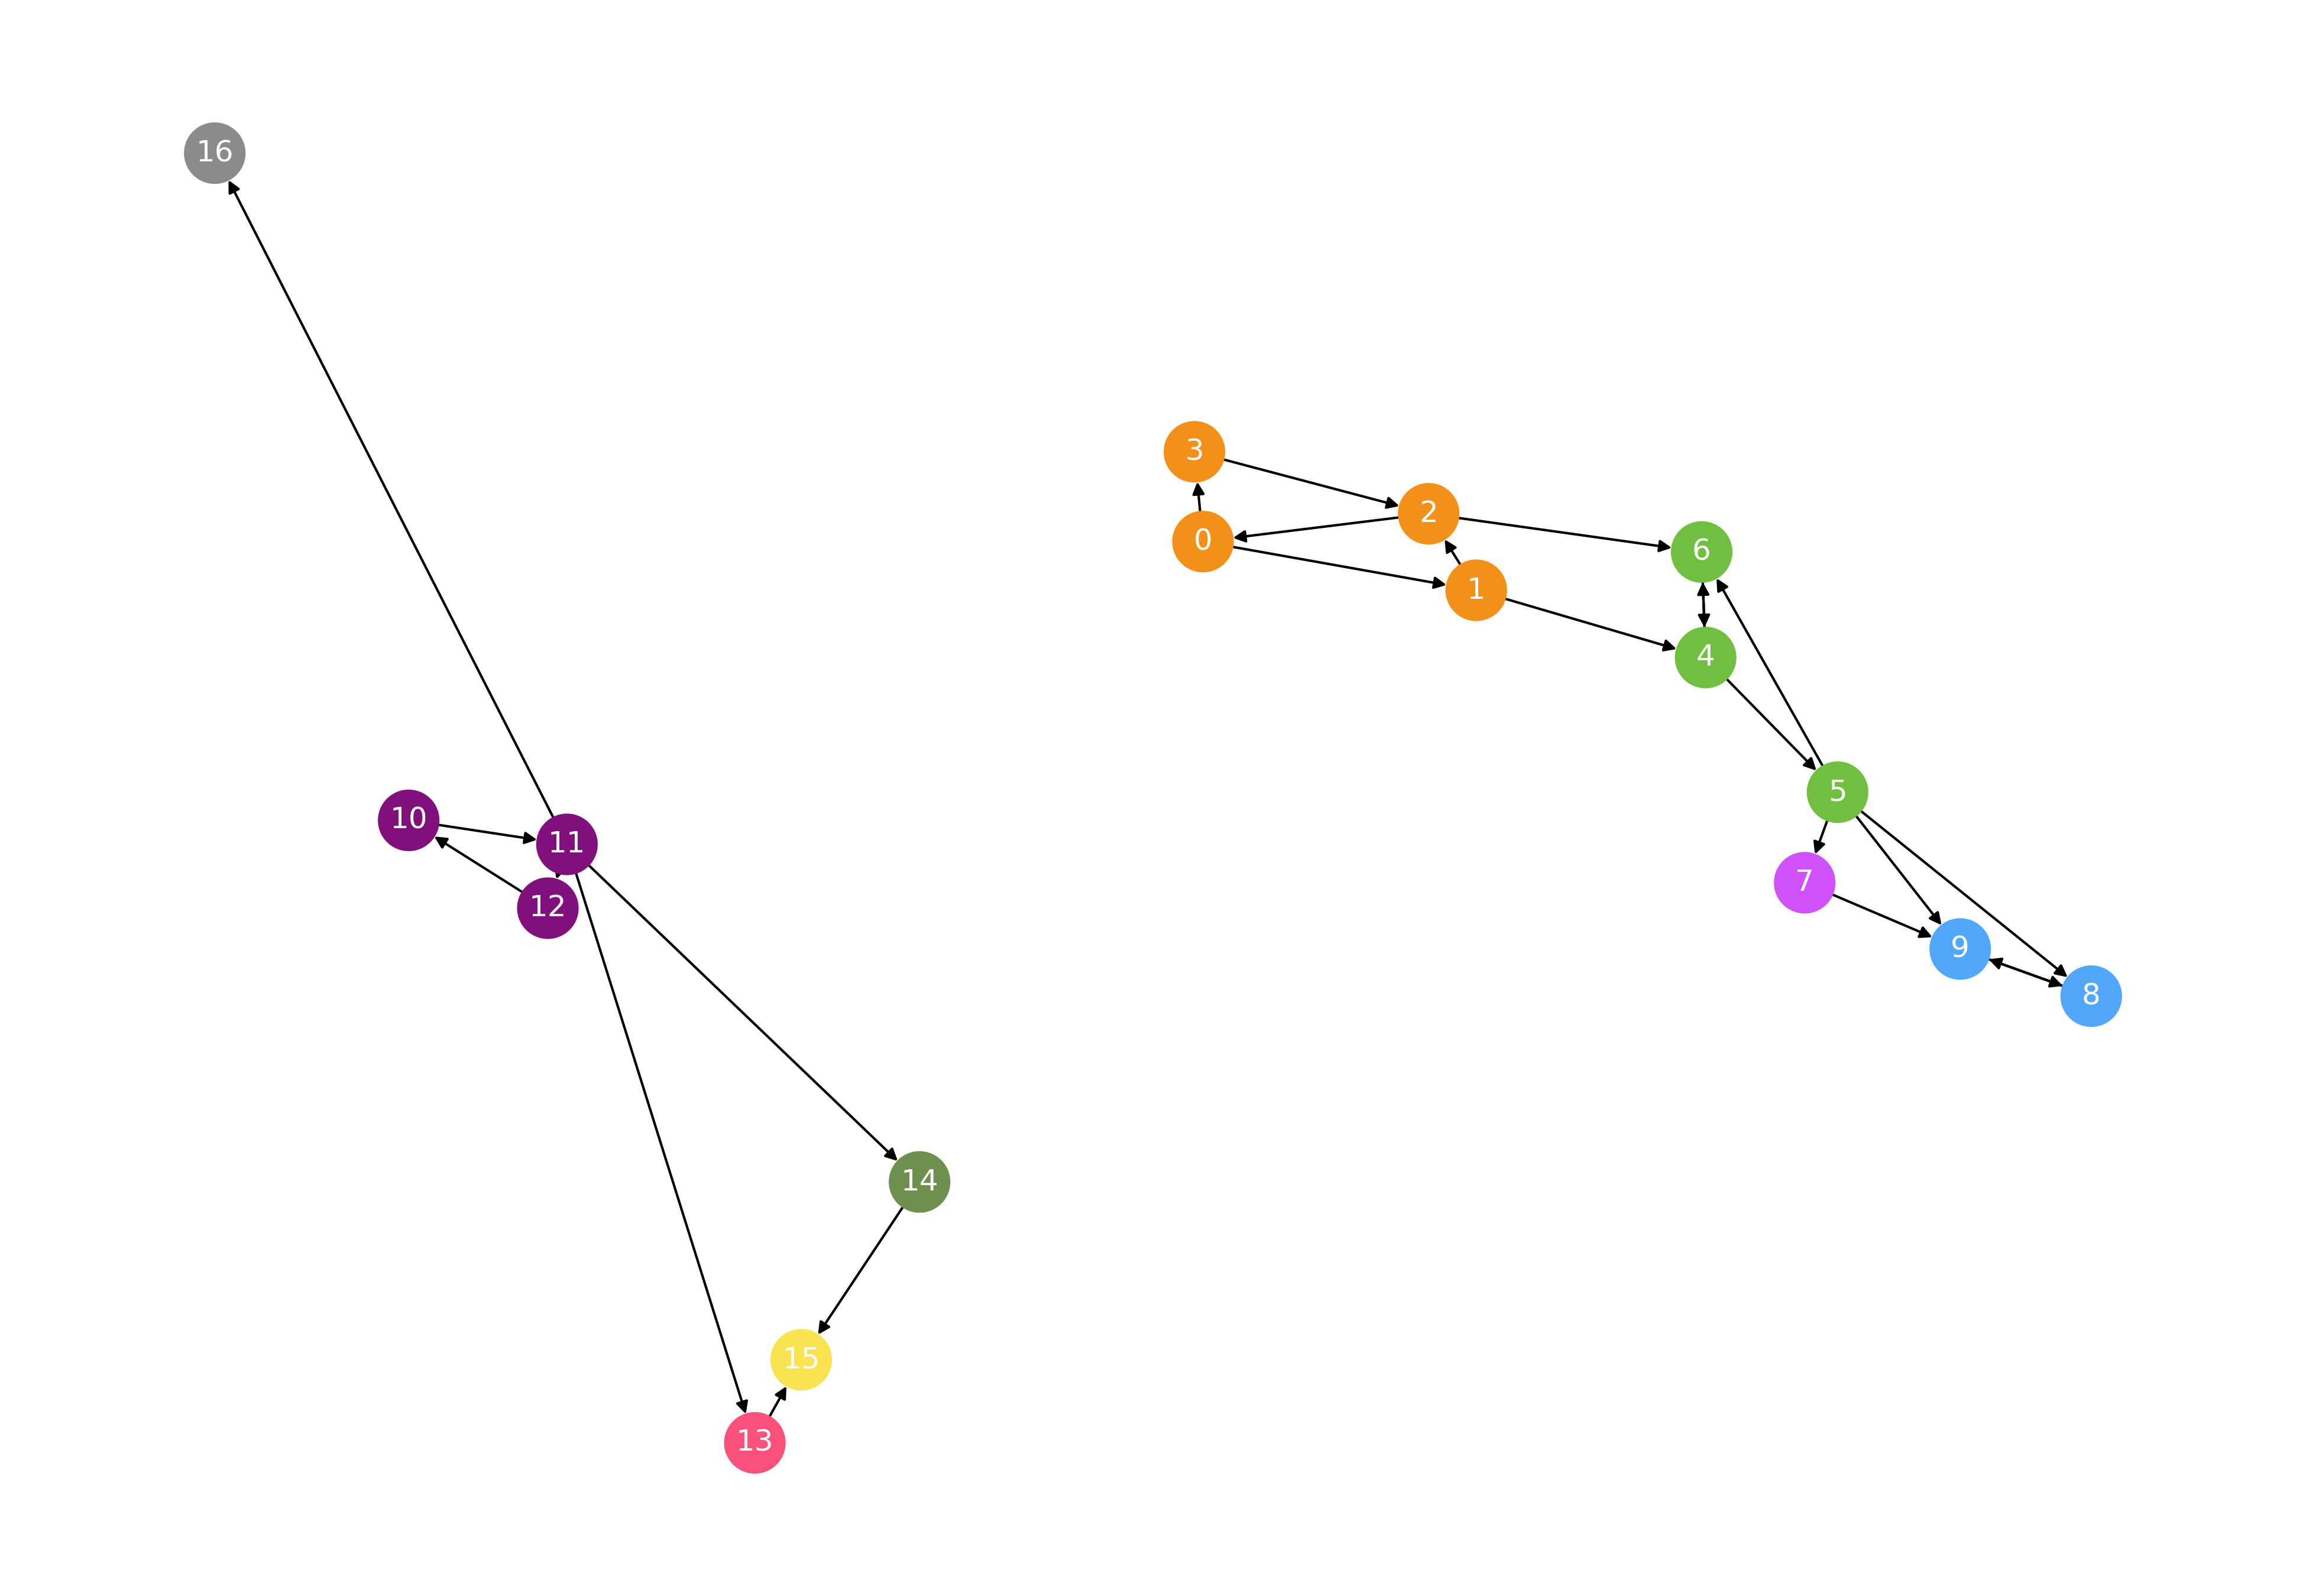

In [25]:
node_colors = []

for node in G_test.nodes:
    for i, comp in enumerate(SCC_test):
        if node in comp:
            node_colors.append(colors[i])
            
nx.draw(G_test, pos=G_pos, node_size=600, node_color=node_colors)
nx.draw_networkx_labels(G_test, pos=G_pos, font_color='white');

On the other hand, for the Higgs network, we have

In [26]:
SCC = strongly_connected_components(G)

We find 36132 components, as expected

In [27]:
print("Our algorithm:", len(SCC))
print("NetworkX:", nx.components.number_strongly_connected_components(G))

Our algorithm: 36132
NetworkX: 36132


We also extract the size of each SCC

In [28]:
SCC_sizes = [len(comp) for comp in SCC]

And the largest WCC has just a few hundred nodes

In [29]:
np.max(SCC_sizes)

322

In [30]:
P_size = pd.DataFrame(list(Counter(SCC_sizes).items()), columns=['size', 'N_size'])
P_size.sort_values('size', inplace=True)
P_size['N_size'] /= P_size['N_size'].sum()

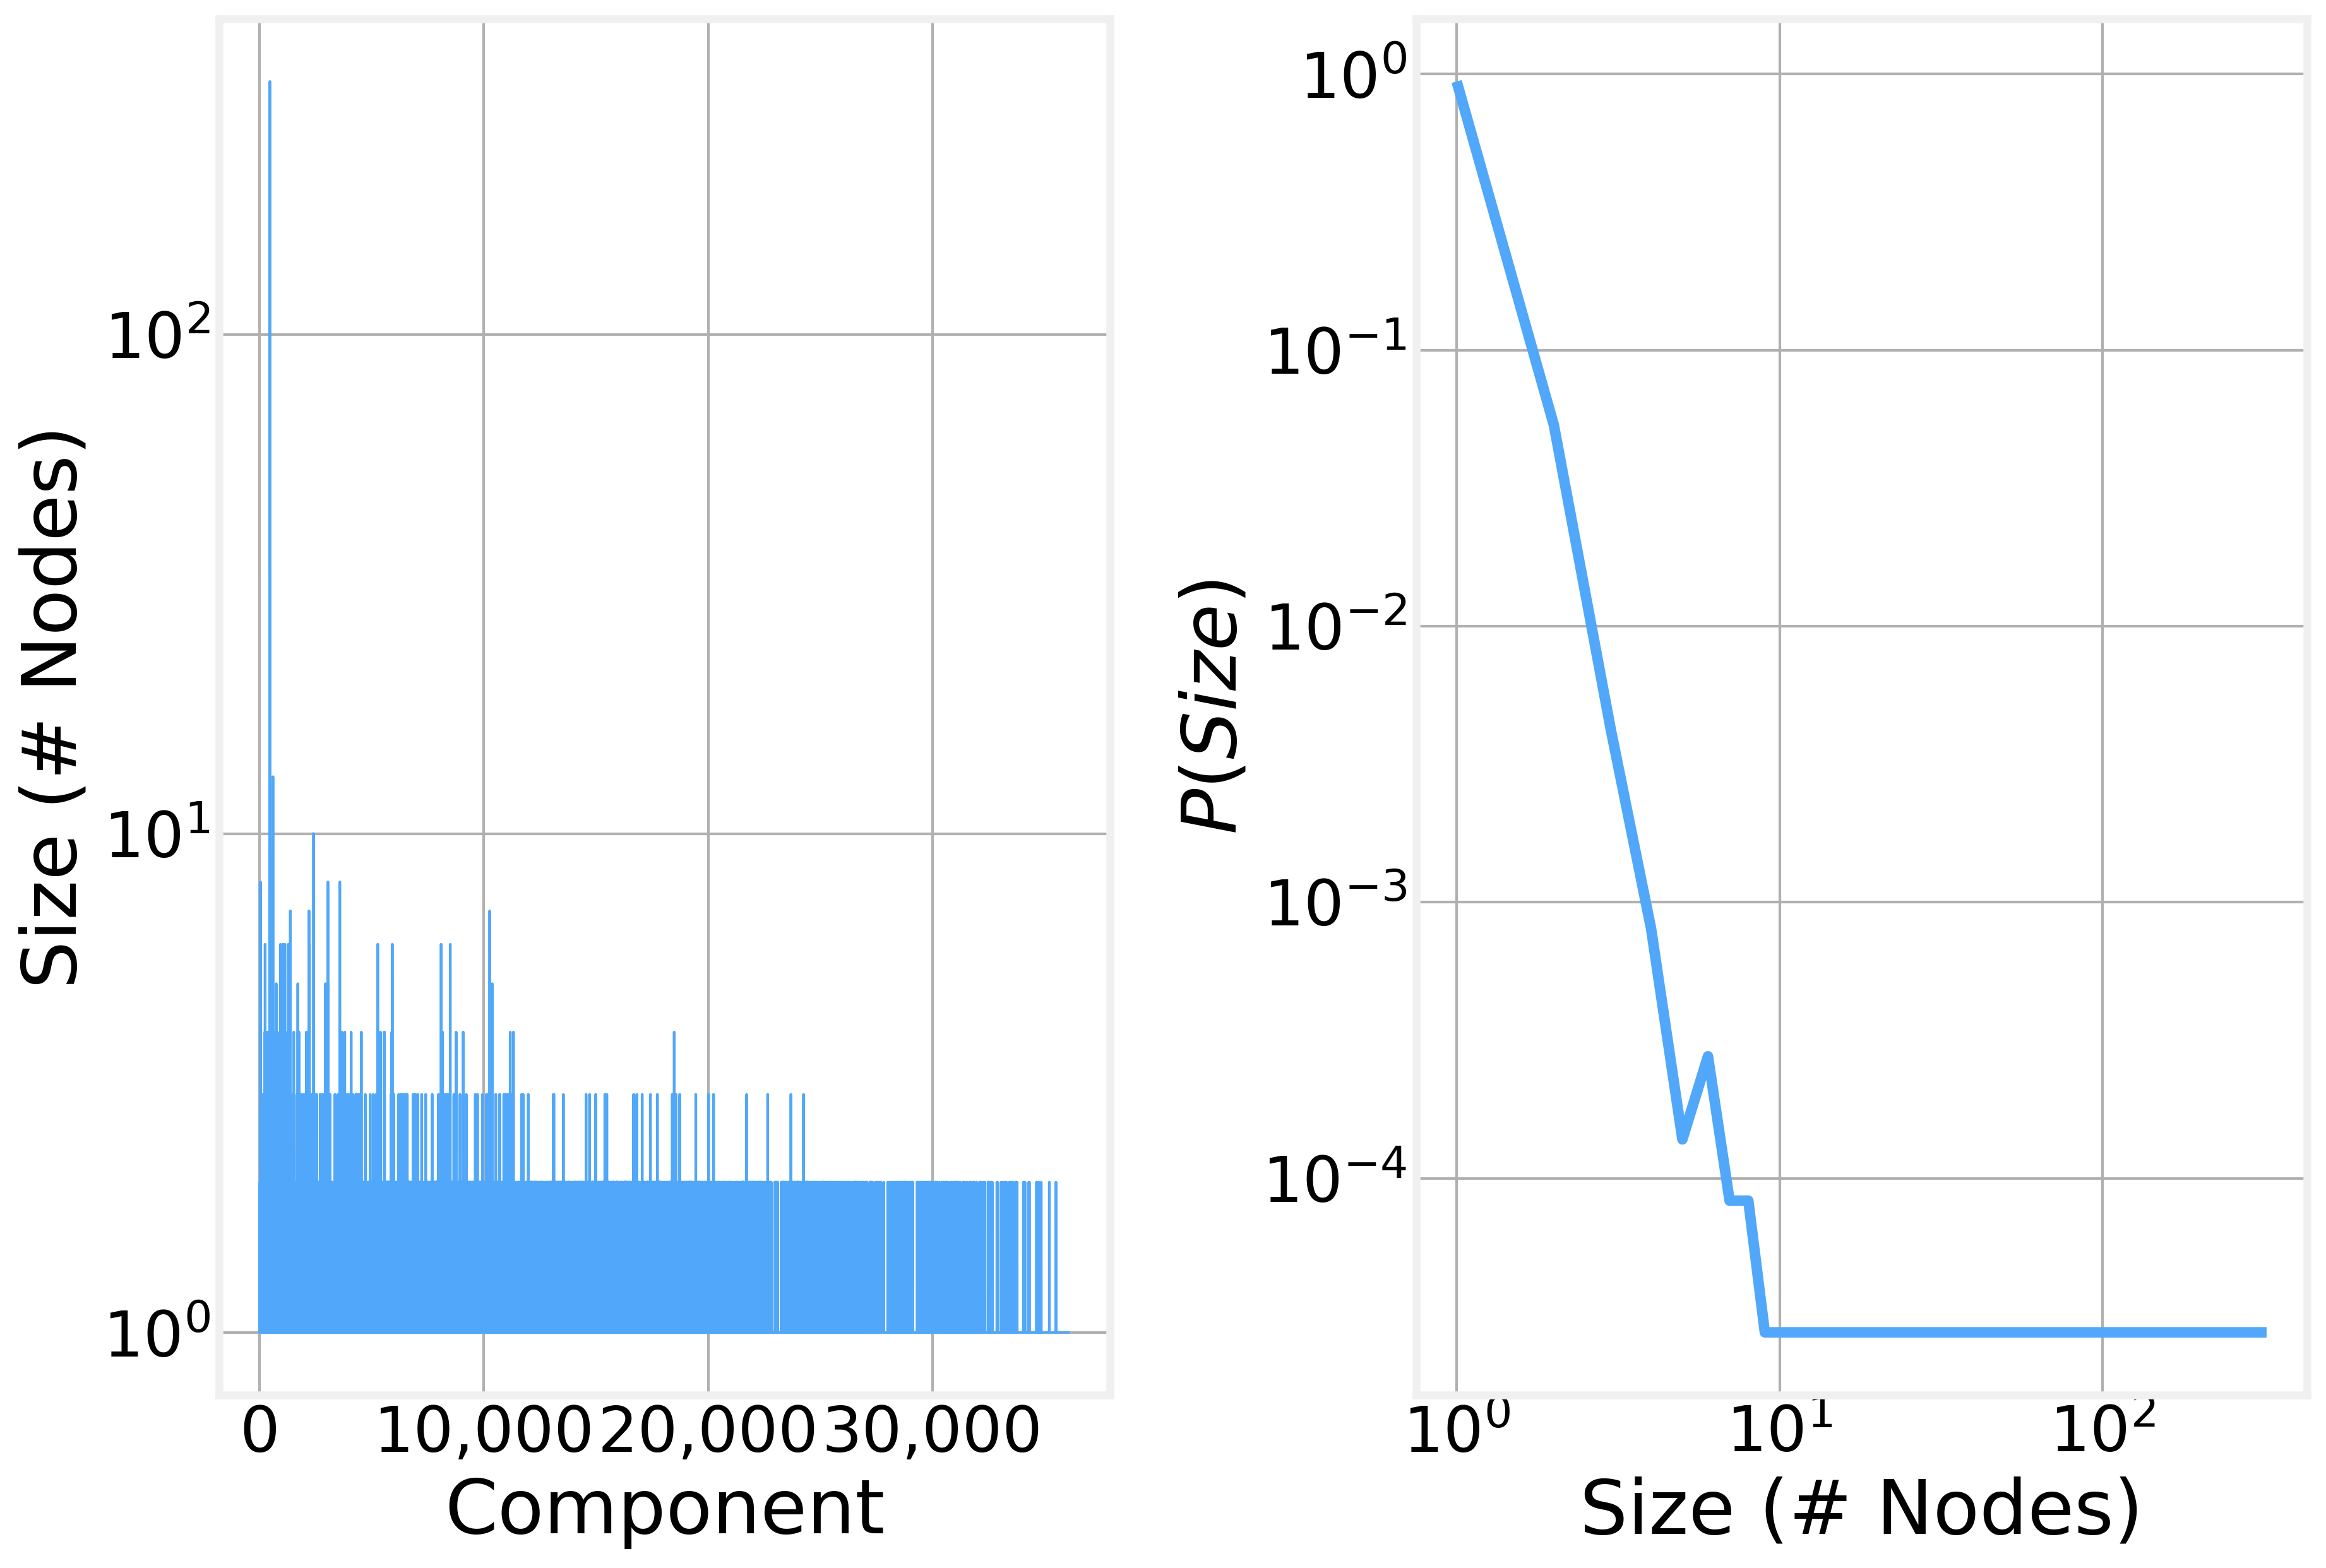

In [31]:
fig, (ax, ax2) = plt.subplots(1, 2)

ax.plot(SCC_sizes, lw=1)
ax.set_yscale('log')
ax.set_xlabel('Component')
ax.set_ylabel('Size (# Nodes)')
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

P_size.plot(x='size', y='N_size', legend=False, ax=ax2)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('Size (# Nodes)')
ax2.set_ylabel(r'$P\left(Size\right)$')
fig.tight_layout()

Here the situation is completely different, with 94% of all components having just a single node.

In [32]:
P_size.iloc[P_size['N_size'].idxmax()]

size      1.000000
N_size    0.940745
Name: 0, dtype: float64

We also extract the largest subgraph

In [33]:
largest_SCC = G.subgraph(SCC[np.argmax(SCC_sizes)])

Which is much smaller that the largest SCC

In [34]:
print('Number of nodes:', largest_SCC.number_of_nodes())
print('Number of edges:', largest_SCC.number_of_edges())

Number of nodes: 322
Number of edges: 708


In [35]:
degrees = dict(largest_SCC.degree())
max_degree = np.max(list(degrees.values()))

In [36]:
np.random.seed(42)
random.seed(42)
pos = nx.layout.kamada_kawai_layout(largest_SCC)

In [37]:
sizes = []
colors = []
for node in largest_SCC.nodes:
    degree = degrees[node]
    sizes.append( degree/ max_degree * 600)
    colors.append(plt.cm.Reds_r(degree / max_degree))

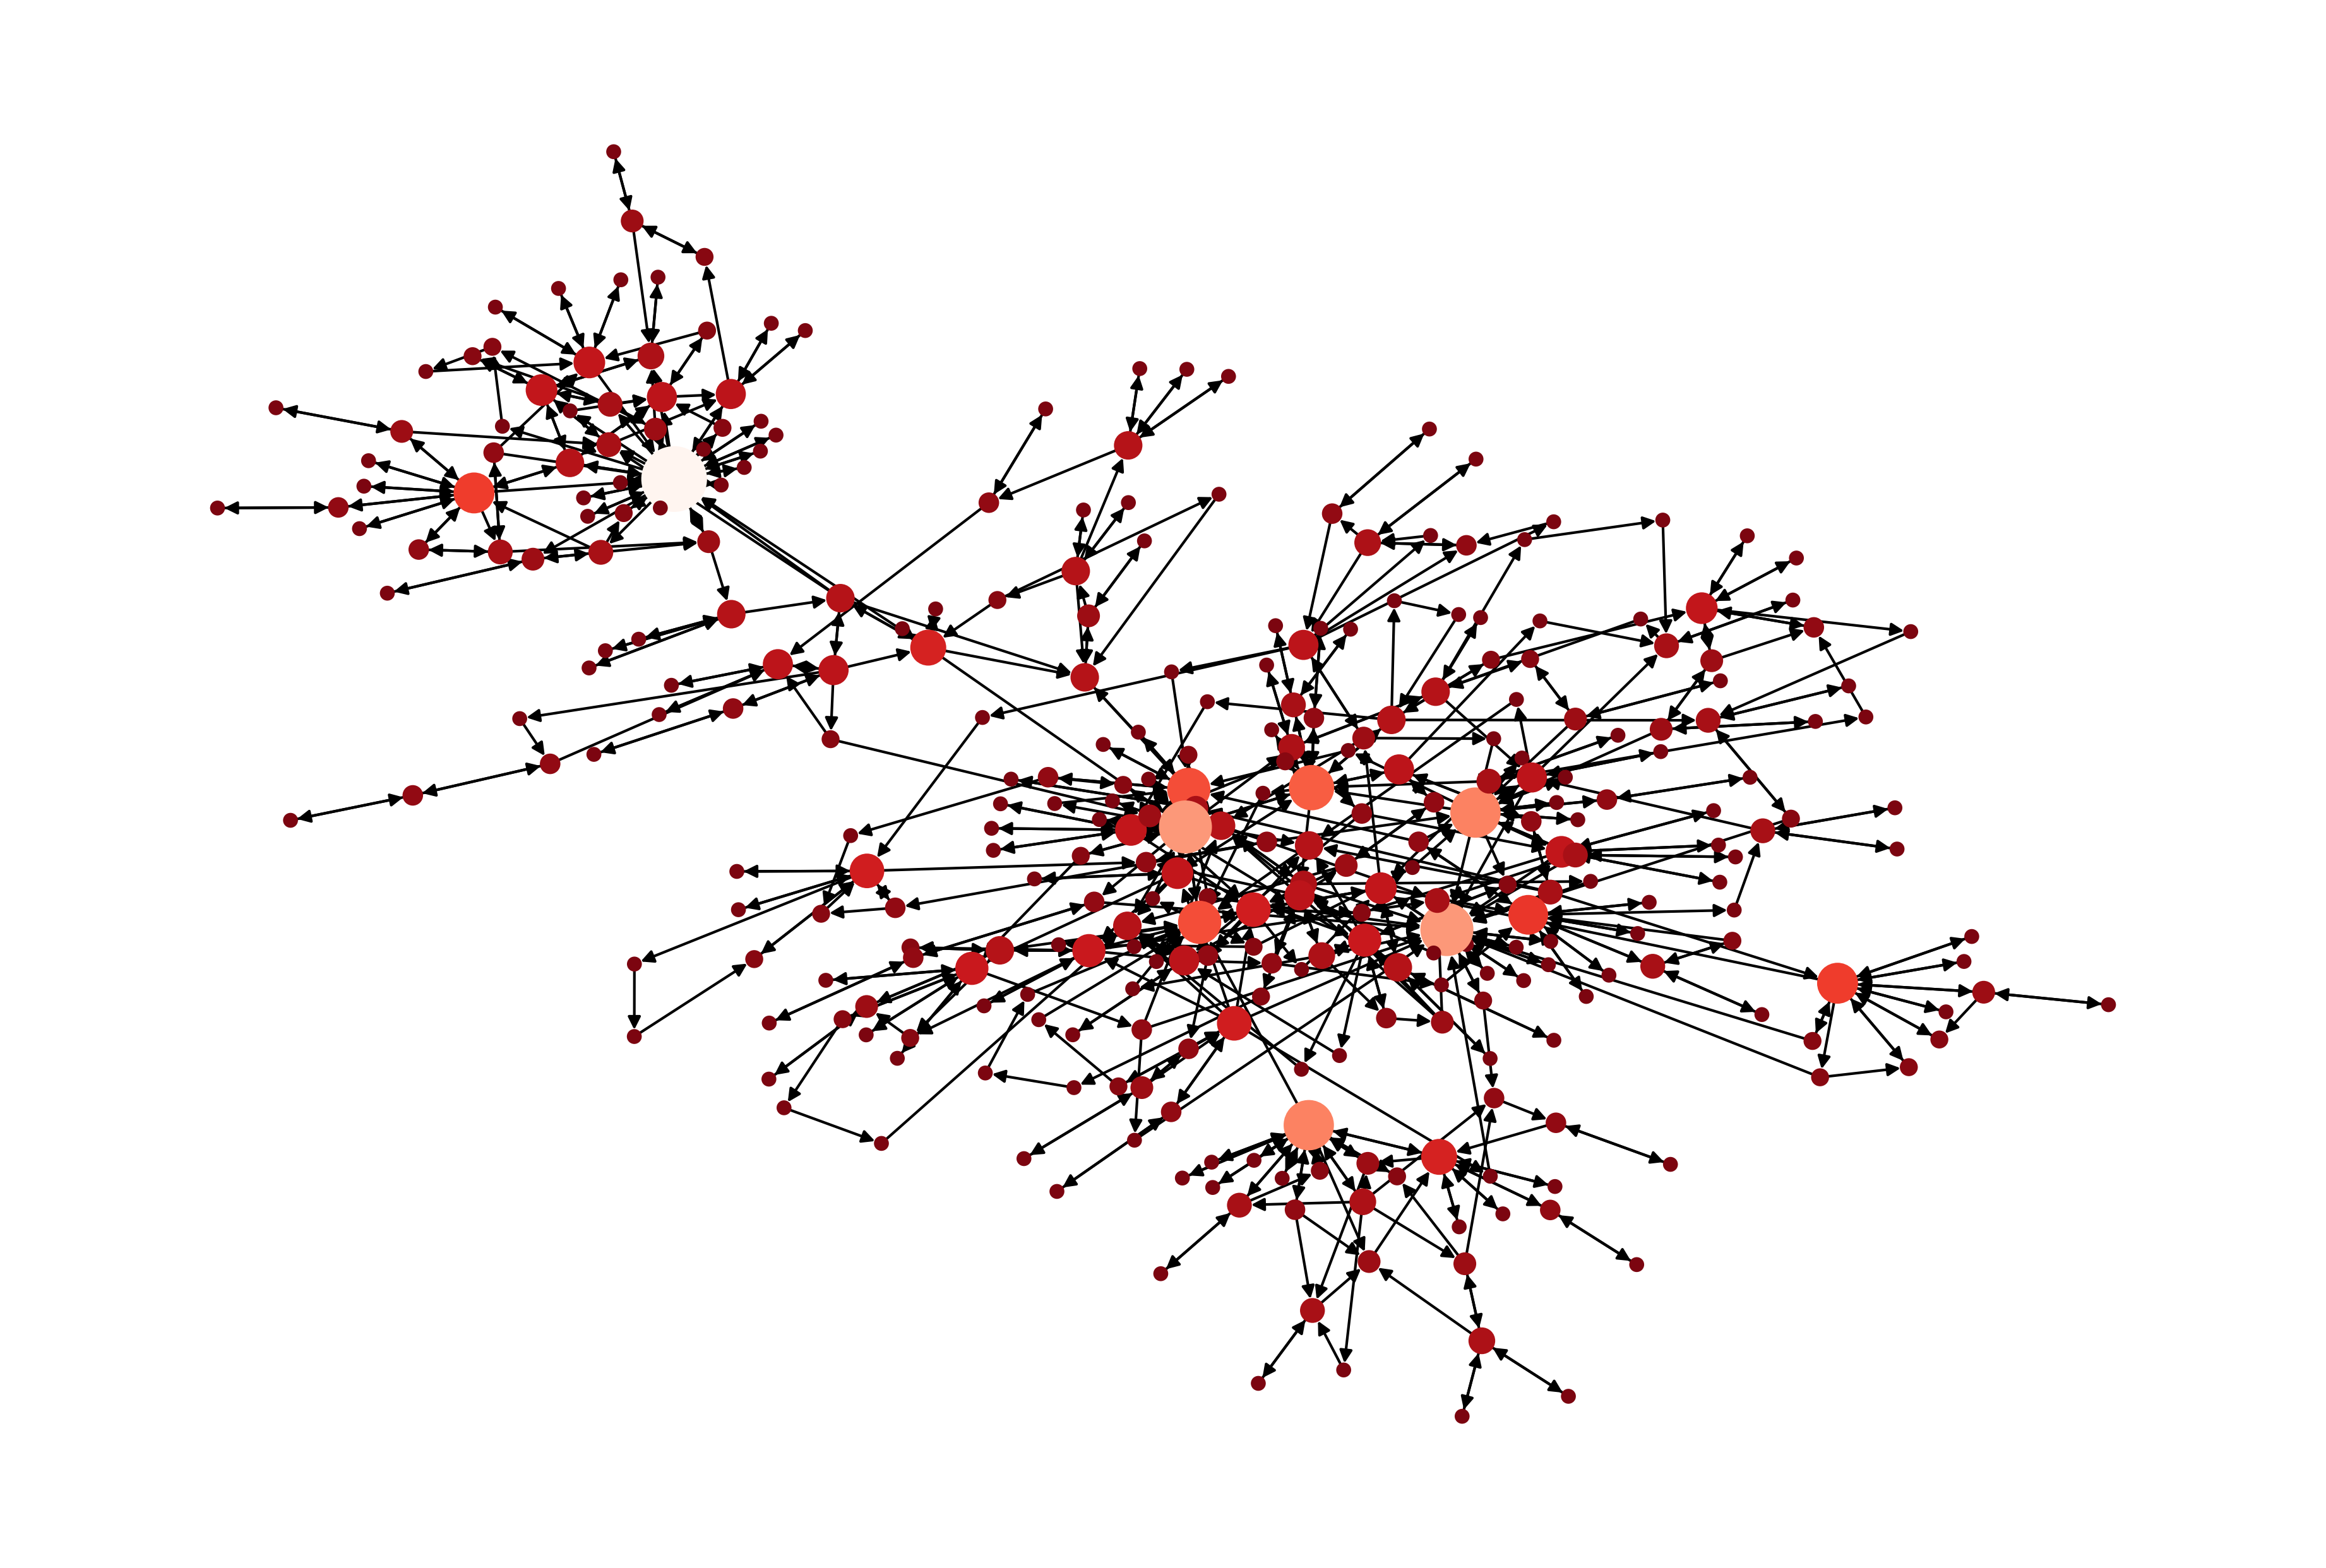

In [38]:
nx.draw_networkx_edges(largest_SCC, pos=pos, node_size=sizes)
nx.draw_networkx_nodes(largest_SCC, pos=pos, node_size=sizes, node_color=colors)
plt.gca().axis('off');

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>